In [23]:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 1. Weather Data

In [2]:
confile = list(pd.read_csv('../../dbcon.csv'))
postgres_db = 'weatherinszeged'
db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(confile[0], confile[1], confile[2], confile[3], postgres_db)

query = f'''
SELECT *
FROM {postgres_db}
;'''

weather = pd.read_sql(query, db_connection)
display(
    weather.isna().mean(),
    weather.info(),
    weather.head(5)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

date                   0.0
summary                0.0
preciptype             0.0
temperature            0.0
apparenttemperature    0.0
humidity               0.0
windspeed              0.0
windbearing            0.0
visibility             0.0
loudcover              0.0
pressure               0.0
dailysummary           0.0
dtype: float64

None

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [42]:
targetvar = 'temperature'
cols = ['humidity', 'windspeed', 'windbearing', 'pressure'] + [targetvar]
weather = weather[cols]
X = weather.drop(columns=[targetvar])
y = weather[targetvar]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = sm.add_constant(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=36)

results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.315e+04
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        01:01:32   Log-Likelihood:            -2.4611e+05
No. Observations:               72339   AIC:                         4.922e+05
Df Residuals:                   72334   BIC:                         4.923e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9155      0.027    441.005      0.000      11.863      11.968
x1            -6.3381      0.028   -229.070      0.000      -6.392      -6.284
x2            -1.3856      0.028    -49.754      0.000      -1.440      -1.331
x3             0.4347      0.027     16.018      0.000       0.382       0.488
x4            -0.0985      0.027     -3.652      0.000      -0.151      -0.046
==============================================================================
Omnibus:                     2240.747   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2462.540
Skew:                          -0.437   Prob(JB):                         0.00
Kurtosis:                       3.232   Cond. No.                         1.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Testing if we meet GMC

In [38]:
def check_GMC(X, X_train, y_train, pval=0.05):
    y_pred = results.predict(X_train)
    errors = y_train - y_pred
    acf_data = acf(errors)[1:]

    print("__________________________________________________________________________________________________________")

    display(f"mean errors: {np.mean(errors)}")

    print("__________________________________________________________________________________________________________")

    plt.scatter(y_pred, errors)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.show()

    bart_stats = st.bartlett(y_pred, errors)
    lev_stats = st.levene(y_pred, errors)
    print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p value is {bart_stats[1]:.3g}")
    print(f"Levene test statistic value is {lev_stats[0]:3g} and p value is {lev_stats[1]:.3g}")
    if (bart_stats[1] < pval) & (lev_stats[1] < pval):
        print(f"both p-values are less than {pval} therefore we reject the null hypothesis and our errors are heteroscedastic")
    elif (bart_stats[1] > pval) & (lev_stats[1] > pval):
        print(f"both p-values are greater than {pval} therefore we accept the null hypothesis and our errors are homoscedastic")
    else:
        print("both p-values do not align and further analysis needs to be done regarding the homoscedasticity of the errors")

    print("__________________________________________________________________________________________________________")

    display(X.corr().abs())

    print("__________________________________________________________________________________________________________")

    plt.plot(acf_data)
    plt.show()
    display(f"Max autocorrelation between errors is: {np.max(abs(acf_data)):.3f}")

    print("__________________________________________________________________________________________________________")

    jb_stats = st.jarque_bera(errors)
    norm_stats = st.normaltest(errors)
    print(f"Jarque-Bera test statistics is {jb_stats[0]:.3g} and p value is {jb_stats[1]:.3f}")
    print(f"Normality test statistics is {norm_stats[0]:.3g} and p value is {norm_stats[1]:.3f}")
    if (jb_stats[1] < pval) & (norm_stats[1] < pval):
        print(f"both p-values are less than {pval} therefore we reject the null hypothesis and our errors are not normally distributed")
    elif (jb_stats[1] > pval) & (norm_stats[1] > pval):
        print(f"both p-values are greater than {pval} therefore we accept the null hypothesis and our errors are normally distributed")
    else:
        print("both p-values do not align and further analysis needs to be done regarding the normality of the errors")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


__________________________________________________________________________________________________________


'mean errors: -2.928985015009514e-15'

__________________________________________________________________________________________________________


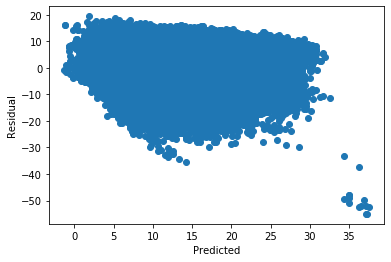

Bartlett test statistic value is 1832.04 and p value is 0
Levene test statistic value is 1754.29 and p value is 0
both p-values are less than 0.05 therefore we reject the null hypothesis and our errors are heteroscedastic
__________________________________________________________________________________________________________


,humidity,windspeed,windbearing,pressure
humidity,1.000000,0.224951,0.000735,0.005454
windspeed,0.224951,1.000000,0.103822,0.049263
windbearing,0.000735,0.103822,1.000000,0.011651
pressure,0.005454,0.049263,0.011651,1.000000


__________________________________________________________________________________________________________


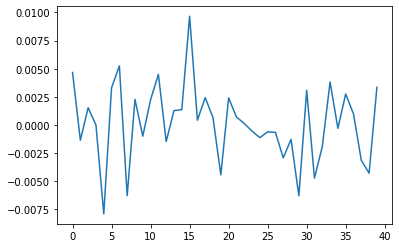

'Max autocorrelation between errors is: 0.010'

__________________________________________________________________________________________________________
Jarque-Bera test statistics is 2.46e+03 and p value is 0.000
Normality test statistics is 2.24e+03 and p value is 0.000
both p-values are less than 0.05 therefore we reject the null hypothesis and our errors are not normally distributed


In [39]:
check_GMC(X, X_train, y_train)

## 2. House Prices

In [43]:
confile = list(pd.read_csv('../../dbcon.csv'))
postgres_db = 'houseprices'
db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(confile[0], confile[1], confile[2], confile[3], postgres_db)

query = f'''
SELECT *
FROM {postgres_db}
;'''

houseprices = pd.read_sql(query, db_connection)
display(
    houseprices.isna().mean(),
    houseprices.info(),
    houseprices.head(5)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 81, dtype: float64

None

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [45]:
targetvar = 'saleprice'
cols = ['mosold', 'lotfrontage', 'lotarea', 'firstflrsf', 'garagearea', 'bedroomabvgr', 'fullbath'] + [targetvar]
houseprices = houseprices[cols].dropna().reset_index(drop=True)
X = houseprices.drop(columns=[targetvar])
y = houseprices[targetvar]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = sm.add_constant(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=36)

results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     193.9
Date:                Wed, 13 May 2020   Prob (F-statistic):          2.40e-174
Time:                        01:02:35   Log-Likelihood:                -10999.
No. Observations:                 900   AIC:                         2.201e+04
Df Residuals:                     892   BIC:                         2.205e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.803e+05   1648.220    109.417      0.000    1.77e+05    1.84e+05
x1          1241.1107   1656.478      0.749      0.454   -2009.938    4492.160
x2          -807.2987   2211.063     -0.365      0.715   -5146.791    3532.193
x3          9779.7986   3033.683      3.224      0.001    3825.811    1.57e+04
x4          2.157e+04   2147.078     10.045      0.000    1.74e+04    2.58e+04
x5          2.904e+04   2065.021     14.062      0.000     2.5e+04    3.31e+04
x6         -1585.2145   1822.383     -0.870      0.385   -5161.873    1991.444
x7          2.314e+04   2003.021     11.553      0.000    1.92e+04    2.71e+04
==============================================================================
Omnibus:                      161.760   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3145.875
Skew:                          -0.090   Prob(JB):                         0.00
Kurtosis:                      12.157   Cond. No.                         3.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__________________________________________________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


'mean errors: -1.2154082974625958e-10'

__________________________________________________________________________________________________________


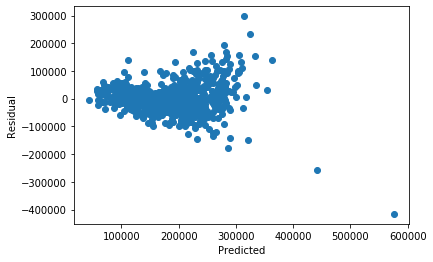

Bartlett test statistic value is 39.3425 and p value is 3.56e-10
Levene test statistic value is 83.4907 and p value is 1.68e-19
both p-values are less than 0.05 therefore we reject the null hypothesis and our errors are heteroscedastic
__________________________________________________________________________________________________________


,mosold,lotfrontage,lotarea,firstflrsf,garagearea,bedroomabvgr,fullbath
mosold,1.000000,0.011200,0.010234,0.030802,0.036494,0.029721,0.069284
lotfrontage,0.011200,1.000000,0.426095,0.457181,0.344997,0.263170,0.198769
lotarea,0.010234,0.426095,1.000000,0.339195,0.220754,0.139944,0.141771
firstflrsf,0.030802,0.457181,0.339195,1.000000,0.511359,0.129834,0.389619
garagearea,0.036494,0.344997,0.220754,0.511359,1.000000,0.066110,0.418023
bedroomabvgr,0.029721,0.263170,0.139944,0.129834,0.066110,1.000000,0.346962
fullbath,0.069284,0.198769,0.141771,0.389619,0.418023,0.346962,1.000000


__________________________________________________________________________________________________________


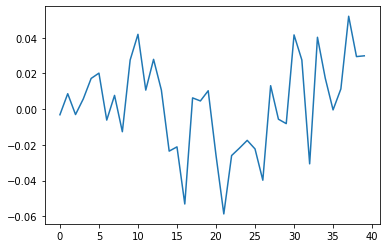

'Max autocorrelation between errors is: 0.059'

__________________________________________________________________________________________________________
Jarque-Bera test statistics is 3.15e+03 and p value is 0.000
Normality test statistics is 162 and p value is 0.000
both p-values are less than 0.05 therefore we reject the null hypothesis and our errors are not normally distributed


In [46]:
check_GMC(X, X_train, y_train)

All conditions are met